<a href="https://colab.research.google.com/github/KarthikeyanBaskaran/SupplyChain-Analytics/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Libraries

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [35]:
df = pd.read_csv('https://raw.githubusercontent.com/KarthikeyanBaskaran/SupplyChain-Analytics/refs/heads/main/Rider-Info.csv')

In [36]:
df.head(2)

,order_time,order_id,order_date,allot_time,accept_time,pickup_time,delivered_time,rider_id,first_mile_distance,last_mile_distance,alloted_orders,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,reassigned_order,session_time,cancelled_time
0,2021-01-26 02:21:35,556753,2021-01-26 00:00:00,2021-01-26 02:21:59,2021-01-26 02:22:08,2021-01-26 02:32:51,2021-01-26 02:49:47,11696,1.5666,2.65,46.0,46.0,0,0.0,621.0,NaN,NaN,NaN,NaN,NaN
1,2021-01-26 02:33:16,556754,2021-01-26 00:00:00,2021-01-26 02:33:57,2021-01-26 02:34:45,2021-01-26 02:50:25,2021-01-26 03:11:15,18117,2.5207,2.76,8.0,8.0,0,0.0,105.0,NaN,NaN,NaN,3.266667,NaN


#### Feature engineering

In [37]:
#Selecting Datatypes
df['order_id'] = df['order_id'].astype('object')
df['rider_id'] = df['rider_id'].astype('object')

df['allot_time'] = pd.to_datetime(df['allot_time'], errors='coerce')
df['accept_time'] = pd.to_datetime(df['accept_time'], errors='coerce')
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df['pickup_time'] = pd.to_datetime(df['pickup_time'], errors='coerce')
df['delivered_time'] = pd.to_datetime(df['delivered_time'], errors='coerce')
df['cancelled_time'] = pd.to_datetime(df['cancelled_time'], errors='coerce')
df['order_time'] = pd.to_datetime(df['order_time'], errors='coerce')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450000 entries, 0 to 449999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   order_time            450000 non-null  datetime64[ns]
 1   order_id              450000 non-null  object        
 2   order_date            450000 non-null  datetime64[ns]
 3   allot_time            450000 non-null  datetime64[ns]
 4   accept_time           449843 non-null  datetime64[ns]
 5   pickup_time           447579 non-null  datetime64[ns]
 6   delivered_time        444782 non-null  datetime64[ns]
 7   rider_id              450000 non-null  object        
 8   first_mile_distance   450000 non-null  float64       
 9   last_mile_distance    450000 non-null  float64       
 10  alloted_orders        433052 non-null  float64       
 11  delivered_orders      432659 non-null  float64       
 12  cancelled             450000 non-null  int64         
 13 

In [39]:
datetime_cols = [
    'order_time', 'order_date', 'allot_time', 'accept_time',
    'pickup_time', 'delivered_time', 'cancelled_time'
]

datecol = []
timecol = []

# Split each datetime column into date and time parts
for col in datetime_cols:
    df[f'{col}_date'] = pd.to_datetime(df[col], errors='coerce').dt.date
    datecol.append(f'{col}_date')
    df[f'{col}_time'] = pd.to_datetime(df[col], errors='coerce').dt.time
    timecol.append(f'{col}_time')

for col in datecol:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [40]:
dat = ['order_date_date', 'allot_time_date',  'accept_time_date',  'pickup_time_date', 'delivered_time_date']
df['same_day_delivery'] = df[dat].apply(lambda row: len(set(row.dropna().apply(lambda x: x.date() if pd.notna(x) else x))) == 1 if row.notna().all() else False, axis=1)

#### EDA

In [41]:
df.isnull().sum() * 100 / len(df)

,0
order_time,0.000000
order_id,0.000000
order_date,0.000000
allot_time,0.000000
accept_time,0.034889
pickup_time,0.538000
delivered_time,1.159556
rider_id,0.000000
first_mile_distance,0.000000
last_mile_distance,0.000000


In [42]:
# Filling alloted order

# Convert to correct types
df['order_date'] = pd.to_datetime(df['order_date'])
df['alloted_orders'] = pd.to_numeric(df['alloted_orders'], errors='coerce')

# Sort for consistency
df = df.sort_values(by=['rider_id', 'order_date'])

# Step 1: Create pivot
pivot = df.pivot_table(index=['order_date', 'rider_id'], values='alloted_orders', aggfunc='first').reset_index()

# Step 2: Create complete grid
riders = df['rider_id'].unique()
dates = df['order_date'].unique()
grid = pd.MultiIndex.from_product([dates, riders], names=['order_date', 'rider_id']).to_frame(index=False)

# Ensure datetime types match
grid['order_date'] = pd.to_datetime(grid['order_date'])
pivot['order_date'] = pd.to_datetime(pivot['order_date'])

# Step 3: Merge to form complete data
pivot_full = grid.merge(pivot, on=['order_date', 'rider_id'], how='left')

# Step 4: Fill missing values
pivot_full['filled_alloted_orders'] = (
    pivot_full.groupby('rider_id')['alloted_orders']
    .ffill()
    .combine_first(
        pivot_full.groupby('rider_id')['alloted_orders'].bfill()
    )
)

# Step 5: Merge back with original df
df = df.merge(
    pivot_full[['order_date', 'rider_id', 'filled_alloted_orders']],
    on=['order_date', 'rider_id'],
    how='left'
)

# Step 6: Fill missing values in original column
df['alloted_orders_filled'] = df['alloted_orders'].combine_first(df['filled_alloted_orders'])
df.drop(columns=['alloted_orders','filled_alloted_orders'], inplace=True)
df.rename(columns={'alloted_orders_filled': 'alloted_orders'}, inplace=True)

In [43]:
df['accept_time_date'].unique()

<DatetimeArray>
['2021-01-27 00:00:00', '2021-01-29 00:00:00', '2021-02-01 00:00:00',
 '2021-02-04 00:00:00', '2021-02-03 00:00:00', '2021-02-05 00:00:00',
 '2021-02-02 00:00:00', '2021-02-06 00:00:00', '2021-01-28 00:00:00',
 '2021-01-26 00:00:00', '2021-01-30 00:00:00', '2021-01-31 00:00:00',
                 'NaT']
Length: 13, dtype: datetime64[ns]

In [44]:
df.isnull().sum()

,0
order_time,0
order_id,0
order_date,0
allot_time,0
accept_time,157
pickup_time,2421
delivered_time,5218
rider_id,0
first_mile_distance,0
last_mile_distance,0


In [45]:
# #fill missing values of accepttime based on riders average accept time

# # --- 1. Convert the relevant columns to datetime ---
# df['allot_time'] = pd.to_datetime(df['allot_time'], errors='coerce')
# df['accept_time'] = pd.to_datetime(df['accept_time'], errors='coerce')

# # --- 2. Calculate the delay (in seconds) from allot_time to accept_time ---
# df['accept_delay'] = (df['accept_time'] - df['allot_time']).dt.total_seconds()

# # --- 3. Compute the average (median) accept delay for each rider ---
# rider_avg_accept_delay = (
#     df[df['accept_delay'].notna()]
#     .groupby('rider_id')['accept_delay']
#     .median()
# )

# # --- 4. Define a function to fill missing accept_time values ---
# def fill_accept_time(row):
#     if pd.isna(row['accept_time']):
#         # Get the rider-specific average delay; if not available, you can use a global average or leave it missing.
#         avg_delay = rider_avg_accept_delay.get(row['rider_id'], None)
#         if avg_delay is not None:
#             # Add the average delay (in seconds) to the allot_time
#             return row['allot_time'] + pd.Timedelta(seconds=avg_delay)
#         else:
#             # Fallback: if no average is available, simply return the allot_time (or consider leaving as NaT)
#             return row['allot_time']
#     else:
#         return row['accept_time']

# # --- 5. Apply the function to fill missing accept_time values ---
# df['accept_time'] = df.apply(fill_accept_time, axis=1)

In [46]:
df['delivered_orders'] = df['delivered_orders'].fillna(df['alloted_orders'])
df['undelivered_orders'] = df['alloted_orders'] - df['delivered_orders']

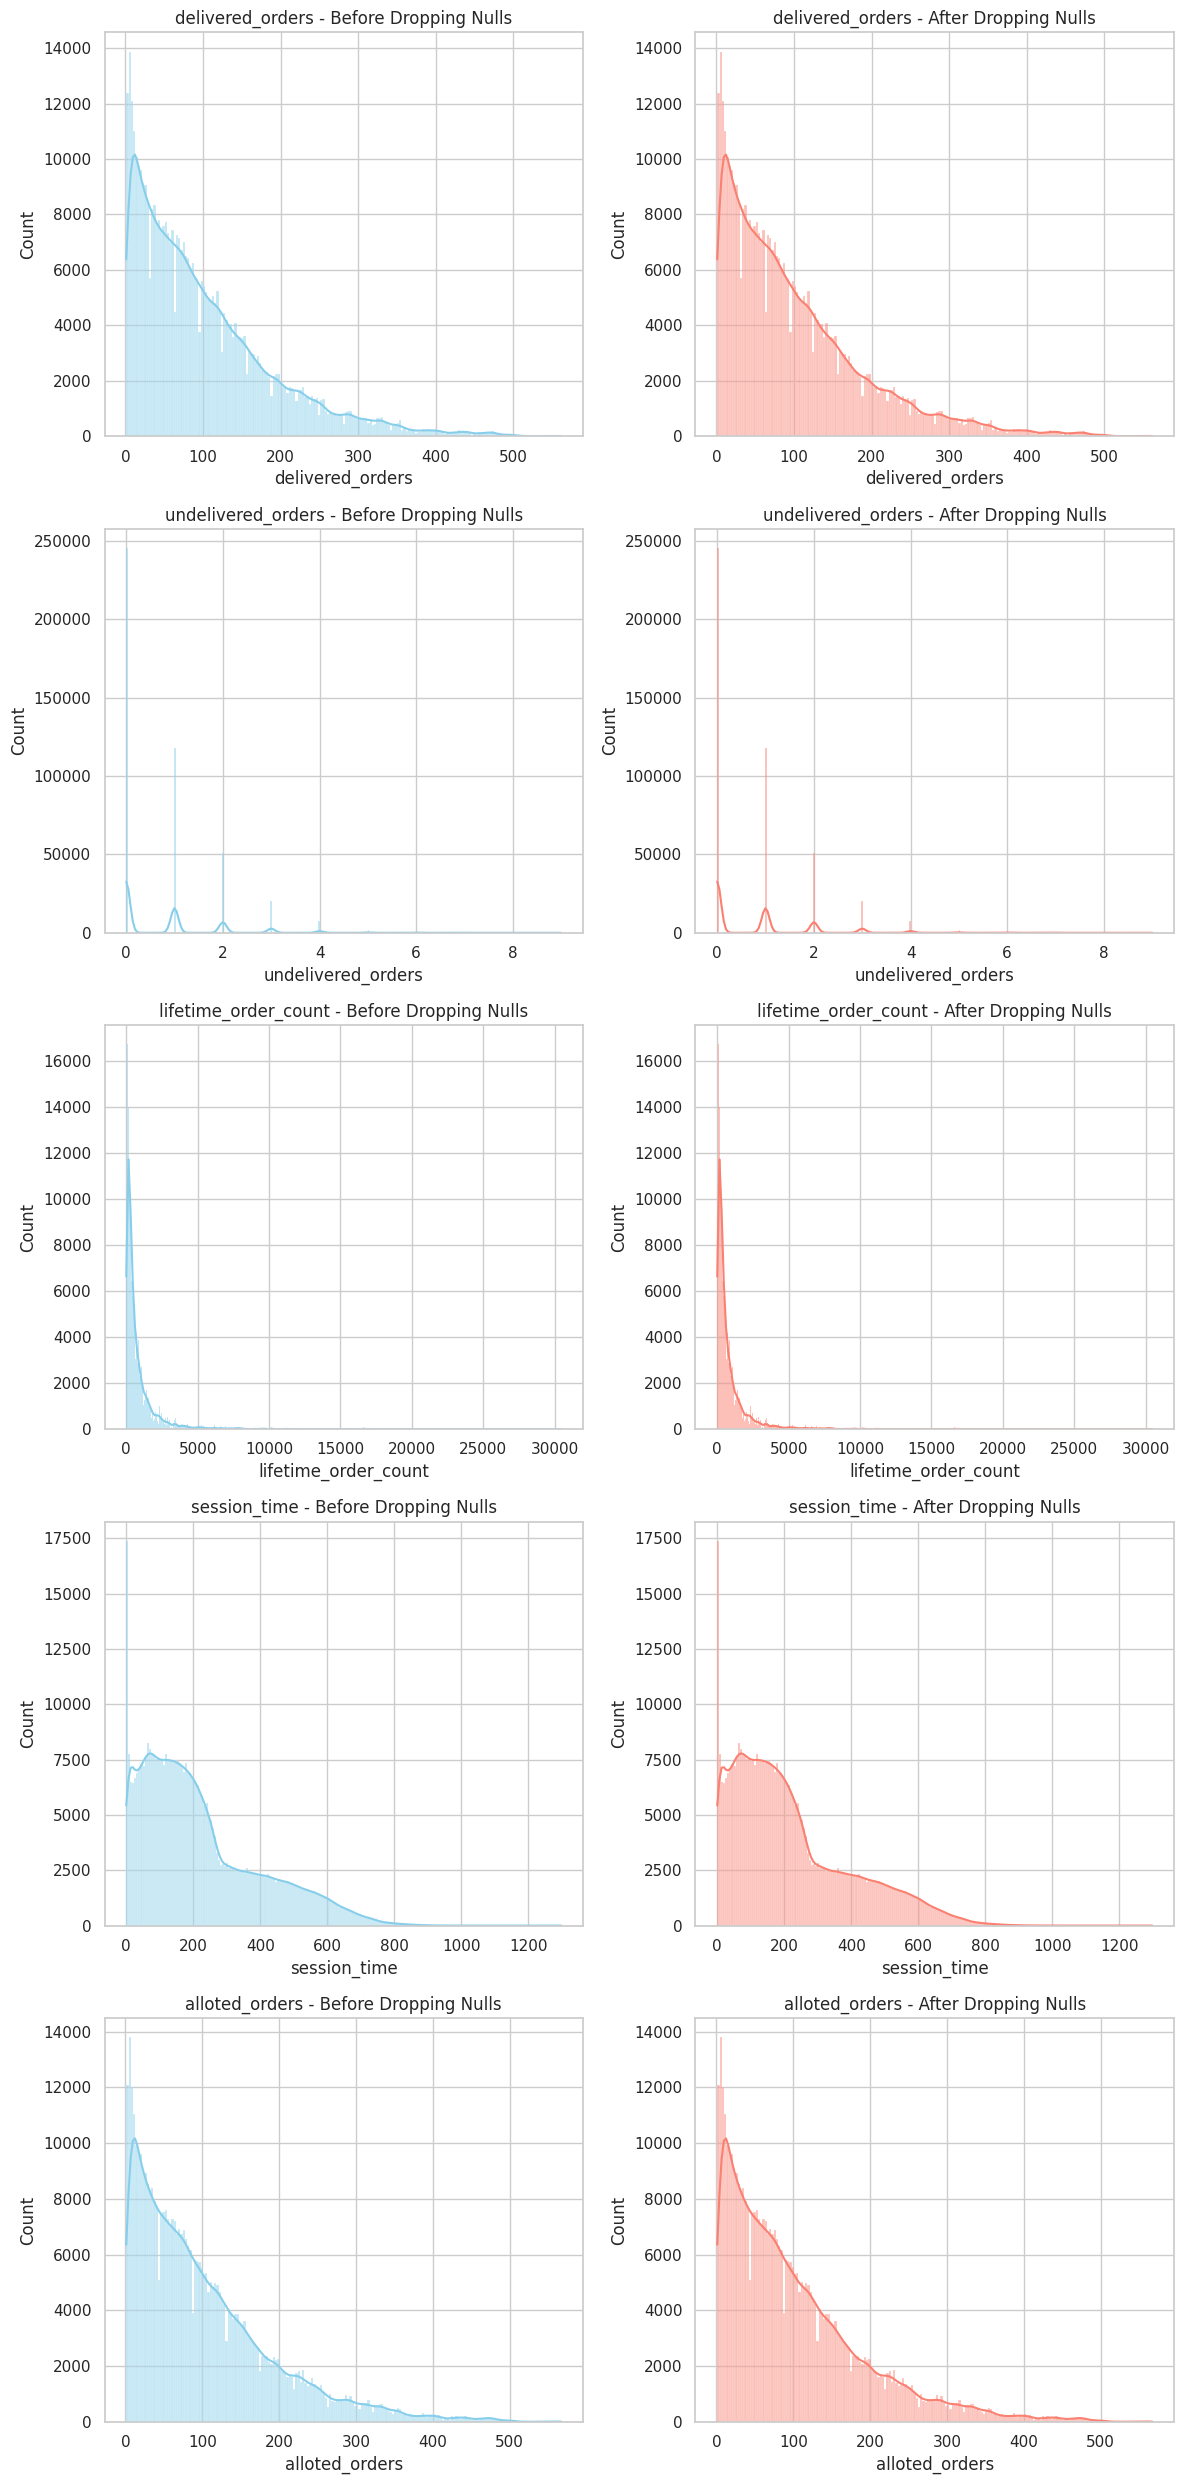

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Copy original DataFrame
df_copy = df.copy()

# Set plot style
sns.set(style='whitegrid')
numeric_cols = ['delivered_orders', 'undelivered_orders', 'lifetime_order_count', 'session_time', 'alloted_orders']

# Create subplots
num_cols = len(numeric_cols)
ncols = 2  # Before and After
nrows = num_cols

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 5 * nrows))

# Loop through each numeric column
for i, col in enumerate(numeric_cols):
    # Plot before dropping nulls
    sns.histplot(df_copy[col], ax=axes[i][0], kde=True, color='skyblue')
    axes[i][0].set_title(f"{col} - Before Dropping Nulls")

    # Plot after dropping nulls
    sns.histplot(df_copy[col].dropna(), ax=axes[i][1], kde=True, color='salmon')
    axes[i][1].set_title(f"{col} - After Dropping Nulls")

# Layout adjustment
plt.tight_layout()
plt.show()


In [48]:
# Step 4: Drop rows with any nulls in numeric columns
df_cleaned = df_copy.dropna(subset=numeric_cols)
# Step 5: Replace original df with cleaned one
df = df_cleaned.copy()

In [49]:
df.isnull().sum()

,0
order_time,0
order_id,0
order_date,0
allot_time,0
accept_time,148
pickup_time,2247
delivered_time,4680
rider_id,0
first_mile_distance,0
last_mile_distance,0


In [50]:
# #fill pickup and delivered time


# # --- 1. Ensure proper datatypes for time columns ---
# time_cols = ['accept_time', 'pickup_time', 'delivered_time']
# for col in time_cols:
#     df[col] = pd.to_datetime(df[col], errors='coerce')

# # --- 2. Calculate time durations (in seconds) for rides with available times ---
# # Duration for pickup: time from accept_time to pickup_time
# df['pickup_duration'] = (df['pickup_time'] - df['accept_time']).dt.total_seconds()

# # Duration for delivery: time from pickup_time to delivered_time
# df['delivery_duration'] = (df['delivered_time'] - df['pickup_time']).dt.total_seconds()

# # --- 3. Compute average time per mile for each segment per rider ---
# # For pickup: average seconds per mile (using first_mile_distance)
# pickup_time_per_mile = (
#     df[df['pickup_duration'].notna()]
#     .groupby('rider_id')
#     .apply(lambda group: (group['pickup_duration'] / group['first_mile_distance']).median())
# )
# pickup_time_per_mile.name = 'avg_time_per_mile_pickup'

# # For delivery: average seconds per mile (using last_mile_distance)
# delivery_time_per_mile = (
#     df[df['delivery_duration'].notna()]
#     .groupby('rider_id')
#     .apply(lambda group: (group['delivery_duration'] / group['last_mile_distance']).median())
# )
# delivery_time_per_mile.name = 'avg_time_per_mile_delivery'

# # Merge these averages back into the main DataFrame on rider_id
# df = df.merge(pickup_time_per_mile, on='rider_id', how='left')
# df = df.merge(delivery_time_per_mile, on='rider_id', how='left')

# # Compute global medians as fallback in case some rider's average is missing
# global_avg_pickup = df.loc[df['avg_time_per_mile_pickup'].notna(), 'avg_time_per_mile_pickup'].median()
# global_avg_delivery = df.loc[df['avg_time_per_mile_delivery'].notna(), 'avg_time_per_mile_delivery'].median()

# # --- 4. Define functions to estimate missing times based on the computed averages ---

# def fill_pickup_time(row):
#     # If pickup_time is missing but accept_time is available
#     if pd.isna(row['pickup_time']) and pd.notna(row['accept_time']):
#         # Use rider-specific average if available, else global average
#         avg_time = row['avg_time_per_mile_pickup'] if pd.notna(row['avg_time_per_mile_pickup']) else global_avg_pickup
#         # Estimate pickup_time: accept_time + (first_mile_distance * avg_time_per_mile)
#         estimated_seconds = row['first_mile_distance'] * avg_time
#         return row['accept_time'] + pd.Timedelta(seconds=estimated_seconds)
#     return row['pickup_time']

# def fill_delivered_time(row):
#     # If delivered_time is missing but pickup_time is available (after filling)
#     if pd.isna(row['delivered_time']) and pd.notna(row['pickup_time']):
#         # Use rider-specific average if available, else global average
#         avg_time = row['avg_time_per_mile_delivery'] if pd.notna(row['avg_time_per_mile_delivery']) else global_avg_delivery
#         # Estimate delivered_time: pickup_time + (last_mile_distance * avg_time_per_mile)
#         estimated_seconds = row['last_mile_distance'] * avg_time
#         return row['pickup_time'] + pd.Timedelta(seconds=estimated_seconds)
#     return row['delivered_time']

# # --- 5. Apply the estimation functions to fill missing values ---
# df['pickup_time'] = df.apply(fill_pickup_time, axis=1)
# df['delivered_time'] = df.apply(fill_delivered_time, axis=1)

# # --- 6. (Optional) Drop temporary columns ---
# # df.drop(columns=['pickup_duration', 'delivery_duration', 'avg_time_per_mile_pickup', 'avg_time_per_mile_delivery'], inplace=True)


In [51]:
# 1. Time Features
df['order_hour'] = df['order_time'].dt.hour
df['order_dayofweek'] = df['order_time'].dt.dayofweek
df['order_weekday'] = df['order_time'].dt.day_name()


In [52]:
df.head(1).T

,0
order_time,2021-01-27 08:47:15
order_id,524758
order_date,2021-01-27 00:00:00
allot_time,2021-01-27 08:51:01
accept_time,2021-01-27 08:51:30
pickup_time,2021-01-27 08:59:18
delivered_time,2021-01-27 09:07:14
rider_id,0
first_mile_distance,1.3086
last_mile_distance,0.08


In [64]:
import numpy as np

# 2. Delivery Duration (in minutes)
df['delivery_duration_m'] = np.where(
    df['delivered_time'].notna(),
    (df['delivered_time'] - df['pickup_time']).dt.total_seconds() / 60,
    0
)

# 3. First Mile Speed (distance / time in seconds)
df['pickupspeed_m/h'] = np.where(
    df['delivered_time'].notna(),
    df['first_mile_distance'] / ((df['pickup_time'] - df['accept_time']).dt.total_seconds().replace(0, np.nan))*3600,
    0
)

# 4. Last Mile Speed (distance / time in seconds)
df['deliveryspeed_m/h'] = np.where(
    df['delivered_time'].notna(),
    df['last_mile_distance'] / ((df['delivered_time'] - df['pickup_time']).dt.total_seconds().replace(0, np.nan))*3600,
    0
)


In [54]:
# # 4. Rider Performance
# df['delivery_rate'] = df['delivered_orders'] / df['alloted_orders'].replace(0, np.nan)
# df['undelivery_rate'] = df['undelivered_orders'] / df['alloted_orders'].replace(0, np.nan)

# # 5. Binary flag for reassignment
# df['was_reassigned'] = (df['reassigned_order'] > 0).astype(int)

In [55]:
# Clean infinities or NaNs from feature division
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [62]:
df['total_distance']=df['first_mile_distance']+df['last_mile_distance']

In [68]:
df[df['rider_id']==16543].T

,411000,411001
order_time,2021-02-02 16:57:07,2021-02-03 15:42:13
order_id,315660,266610
order_date,2021-02-02 00:00:00,2021-02-03 00:00:00
allot_time,2021-02-02 16:57:26,2021-02-03 15:45:03
accept_time,2021-02-02 16:58:13,2021-02-03 15:45:09
pickup_time,NaT,2021-02-03 18:35:09
delivered_time,NaT,2021-02-03 18:35:13
rider_id,16543,16543
first_mile_distance,1.4195,2.2638
last_mile_distance,2.85,2.05


In [81]:
high_speed_indices = df[df['deliveryspeed_m/h'] >= 40].index
df.drop(index=high_speed_indices, inplace=True)
print(len(high_speed_indices))

1018


In [86]:
high_speed_indices = df[df['pickupspeed_m/h'] >= 40].index
df.drop(index=high_speed_indices, inplace=True)
print(len(high_speed_indices))

711


In [94]:
df[df['same_day_delivery']==True].describe().T

,count,mean,min,25%,50%,75%,max,std
order_time,435213,2021-01-31 18:09:06.511087616,2021-01-26 02:33:16,2021-01-28 16:50:15,2021-01-31 15:52:29,2021-02-03 14:51:35,2021-02-06 10:03:24,NaN
order_id,435213.0,369639.704793,118350.0,258159.0,370186.0,482858.0,594842.0,131038.451504
order_date,435213,2021-01-31 04:53:51.267448064,2021-01-26 00:00:00,2021-01-28 00:00:00,2021-01-31 00:00:00,2021-02-03 00:00:00,2021-02-06 00:00:00,NaN
allot_time,435213,2021-01-31 18:10:12.861385472,2021-01-26 02:33:57,2021-01-28 16:51:26,2021-01-31 15:53:18,2021-02-03 14:52:38,2021-02-06 10:43:52,NaN
accept_time,435213,2021-01-31 18:11:13.597670912,2021-01-26 02:34:45,2021-01-28 16:52:32,2021-01-31 15:54:06,2021-02-03 14:53:32,2021-02-06 10:44:51,NaN
pickup_time,435213,2021-01-31 18:25:07.320153600,2021-01-26 02:50:25,2021-01-28 17:04:38,2021-01-31 16:08:49,2021-02-03 15:08:16,2021-02-06 10:59:51,NaN
delivered_time,435213,2021-01-31 18:40:43.682693120,2021-01-26 03:11:15,2021-01-28 17:19:16,2021-01-31 16:22:50,2021-02-03 15:24:09,2021-02-06 14:00:48,NaN
rider_id,435213.0,7648.602705,0.0,2739.0,6625.0,11782.0,21566.0,5529.675851
first_mile_distance,435213.0,1.22438,0.000134,0.5368,1.1332,1.8454,11.6741,0.83938
last_mile_distance,435213.0,2.96125,0.0,1.47,2.66,4.21,21.12,1.874745


In [100]:
df

,order_id,rider_id,first_mile_distance,last_mile_distance,delivered_orders,cancelled,undelivered_orders,lifetime_order_count,reassignment_method,reassignment_reason,...,alloted_orders,order_hour,order_dayofweek,order_weekday,delivery_duration_m,first_mile_speed,last_mile_speed,pickupspeed_m/h,deliveryspeed_m/h,total_distance
0,524758,0,1.308600,0.08,28.0,0,1.0,8734.0,NaN,NaN,...,29.0,8,2,Wednesday,7.933333,6.515851,0.605042,10.066154,0.605042,1.388600
1,442759,0,1.347700,0.03,28.0,0,0.0,8734.0,NaN,NaN,...,28.0,8,4,Friday,2.633333,4.087380,0.683544,4.542809,0.683544,1.377700
2,442767,0,1.631400,2.22,28.0,1,0.0,8734.0,auto,Reassign,...,28.0,8,4,Friday,0.000000,0.000000,0.000000,0.000000,0.000000,3.851400
3,339093,0,0.535600,1.01,25.0,0,1.0,8734.0,NaN,NaN,...,26.0,14,0,Monday,7.483333,1.490077,8.097996,1.640987,8.097996,1.545600
4,341573,0,2.595600,1.56,25.0,0,1.0,8734.0,auto,Reassignment Request from SE portal.,...,26.0,14,0,Monday,7.316667,10.916075,12.792711,20.051845,12.792711,4.155600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449993,593575,21560,0.577400,1.34,18.0,0,0.0,252.0,NaN,NaN,...,18.0,17,1,Tuesday,12.016667,0.841214,6.690707,0.871547,6.690707,1.917400
449994,593623,21561,1.105300,2.31,1.0,1,0.0,213.0,NaN,NaN,...,1.0,17,1,Tuesday,0.000000,0.000000,0.000000,0.000000,0.000000,3.415300
449997,594538,21564,0.171028,0.84,1.0,1,1.0,55.0,NaN,NaN,...,2.0,17,1,Tuesday,0.000000,0.000000,0.000000,0.000000,0.000000,1.011028
449998,594591,21565,0.008342,4.62,1.0,0,0.0,31.0,NaN,NaN,...,1.0,17,1,Tuesday,22.200000,0.032468,12.486486,0.035085,12.486486,4.628342


In [105]:
len(df[df['total_distance']>=10])

4644

In [95]:
df.drop(columns=datetime_cols, inplace=True)

In [96]:
df.to_csv('cleaned_data.csv', index=False)